In [528]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from IPython.display import display
from datetime import datetime, timedelta

# Data preprocessing

Go to the Bugs analysis section for visualization. The data preprocessing part only filters transforms data for utilization in subsequent part

In [529]:
# Lines added to make dataframes with large number of columns get displayed in their entirety
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [530]:
df = pd.read_csv('../datasets/alerts_data.csv', index_col=False)

<ipython-input-530-3b425d876bd6>:1: DtypeWarning: Columns (24,26) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/content/alerts_data.csv', index_col=False)


In [531]:
# converting time-based columns from type string to type timestamp
alerts_timedate_cols = ['alert_creation_timestamp', 'alert_first_triaged', 'alert_triage_due_date', 'alert_bug_due_date', 'alert_bug_updated']
for i in alerts_timedate_cols:
  df[i] = pd.to_datetime(df[i], format='%Y-%m-%dT%H:%M:%S.%f')
df['alert_push_timestamp'] = pd.to_datetime(df['alert_push_timestamp'], unit='s')
df.drop(columns=['test_series_signature_framework_id'], inplace=True)

In [532]:
alert_status_mapping = {
    0: "untriaged",
    1: "downstream",
    2: "reassigned",
    3: "invalid",
    4: "improvement",
    5: "investigating",
    6: "wontfix",
    7: "fixed",
    8: "backedout"
}
framework_mapping = {
    1: "talos",
    2: "build_metrics",
    4: "awsy",
    6: "platform_microbench",
    10: "raptor",
    11: "js-bench",
    12: "devtools",
    13: "browsertime",
    15: "mozperftest",
    16: "fxrecord"
}
test_status_mapping = {
    0: "untriaged",
    1: "downstream",
    2: "reassigned",
    3: "invalid",
    4: "acknowledged"
}

In [533]:
df['alert_framework'] = df['alert_framework'].map(framework_mapping)
df['alert_status'] = df['alert_status'].map(alert_status_mapping)
df['test_status'] = df['test_status'].map(test_status_mapping)

In [534]:
alerts_df = df.filter(like='alert_').drop_duplicates()

In [535]:
df_alerts_bugs = alerts_df[alerts_df['alert_bug_number'].notna()]
df_alerts_bugs.rename(columns={'alert_bug_number': 'bug_id'}, inplace=True)
df_alerts_bugs["bug_id"] = df_alerts_bugs["bug_id"].astype(int)

<ipython-input-535-fa591d516279>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_alerts_bugs.rename(columns={'alert_bug_number': 'bug_id'}, inplace=True)
<ipython-input-535-fa591d516279>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_alerts_bugs["bug_id"] = df_alerts_bugs["bug_id"].astype(int)


# Bugs data analysis

In [536]:
bug_related_alerts_perc = (df_alerts_bugs.shape[0] / alerts_df.shape[0]) * 100
print(f"Percentage of alerts with associated bugs : {bug_related_alerts_perc:.2f} %")

Percentage of alerts with associated bugs : 16.16 %


In [537]:
df_bugs = pd.read_csv('../datasets/bugs_data.csv', index_col=False)

In [538]:
display(df_bugs.head(5))

,bug_id,bug_resolution,bug_type,bug_component,bug_summary,bug_classification,bug_status,bug_creation_time,bug_url,bug_last_change_time,bug_severity,bug_priority,bug_product,bug_is_confirmed,bug_votes,bug_is_open,bug_assigned_to,bug_cf_last_resolved,bug_cf_performance_impact,bug_version,bug_whiteboard,bug_platform,bug_keywords,IsPerformanceBug
0,1171441,FIXED,defect,Web Audio,Add a way to determine if an AudioParam is con...,Components,RESOLVED,2015-06-04T13:39:53Z,NaN,2023-09-28T13:43:42Z,S3,P3,Core,True,0,False,karlt@mozbugz.karlt.net,2023-09-23T09:27:24Z,---,unspecified,NaN,Unspecified,"perf, perf-alert",True
1,1812589,FIXED,task,Raptor,"Ensure the CPU frequency, and other optimizati...",Components,RESOLVED,2023-01-26T13:36:00Z,NaN,2023-09-02T15:35:04Z,S2,P1,Testing,True,0,False,aglavic@mozilla.com,2023-06-20T21:29:37Z,NaN,unspecified,[fxp],Unspecified,perf-alert,True
2,1814798,FIXED,enhancement,Memory Allocator,Allow PHC to be enabled by a pref,Components,RESOLVED,2023-02-03T02:57:55Z,NaN,2023-11-22T19:45:14Z,--,P2,Core,True,0,False,pbone@mozilla.com,2023-09-18T14:50:03Z,---,unspecified,NaN,All,perf-alert,True
3,1819275,FIXED,defect,Graphics: Text,[macOS] Attempt to avoid the main thread being...,Components,RESOLVED,2023-02-28T09:42:14Z,NaN,2023-10-03T14:00:42Z,S3,--,Core,True,0,False,jfkthame@gmail.com,2023-09-27T03:55:10Z,---,unspecified,NaN,Unspecified,NaN,False
4,1821228,FIXED,task,Toolchains,Update builders to rustc 1.70,Developer Infrastructure,RESOLVED,2023-03-09T00:24:44Z,NaN,2023-07-23T20:09:35Z,--,--,Firefox Build System,True,0,False,mh+mozilla@glandium.org,2023-07-15T09:40:11Z,NaN,unspecified,NaN,Unspecified,perf-alert,True


In [539]:
bugs_datetime_cols = ["bug_creation_time", "bug_last_change_time", "bug_cf_last_resolved"]
for i in bugs_datetime_cols:
  df_bugs[i] = pd.to_datetime(df_bugs[i], format='%Y-%m-%dT%H:%M:%SZ')

In [540]:
df_alerts_bugs = pd.merge(df_alerts_bugs, df_bugs, on='bug_id', how='inner')

In [541]:
#delta_columns = ['delta_push_to_alert_creation','delta_alert_creation_to_first_triage','delta_alert_creation_to_triage_duedate','delta_alert_first_triaged_to_bug_creation']
delta_columns = [
    ["delta_alert_push_to_bug_last_resolved", "bug_cf_last_resolved", "alert_push_timestamp", "Time between an alert push and resolving its associated bug"],
    ["delta_alert_creation_to_bug_last_resolved", "bug_cf_last_resolved", "alert_creation_timestamp", "Time between performance alert creation and resolving its associated bug"],
    ["delta_bug_creation_to_bug_last_resolved", "bug_cf_last_resolved", "bug_creation_time", "Time between performance bug creation and its resolving"],
    ["delta_bug_due_date_to_bug_last_resolved", "alert_bug_due_date", "bug_cf_last_resolved", "Time between performance bug resolving date and its due data"]
]

delta_columns_extended = [
    ["delta_push_to_alert_creation", "alert_creation_timestamp", "alert_push_timestamp", "Time between pushing a regression and creating its associated alert"],
    ["delta_alert_creation_to_first_triage", "alert_first_triaged", "alert_creation_timestamp", "Time between alert creation and its first triage"],
    ["delta_alert_creation_to_triage_duedate", "alert_triage_due_date", "alert_creation_timestamp", "Time between alert creation and its triage duedate"],
    ["delta_alert_first_triaged_to_bug_creation", "alert_bug_due_date", "alert_triage_due_date", "Time between alert triggering and creating its associated bug"]
]
def subtract_cols(dataf, resulting_column, first_column, second_column):
  dataf[resulting_column] = (dataf[first_column] - dataf[second_column]).dt.total_seconds() / (3600 * 24)
  dataf[resulting_column] = pd.to_numeric(dataf[resulting_column], errors='coerce')
  dataf[resulting_column] = dataf[resulting_column].where(dataf[resulting_column].notna() & dataf[resulting_column].apply(lambda x: isinstance(x, (int, float))), None)
  dataf[resulting_column] = dataf[resulting_column].apply(lambda x: int(x) if pd.notna(x) else np.nan)
def bulk_subtract(dataf, delta_cols):
  for col_attr in delta_cols:
    result = col_attr[0]
    first_col = col_attr[1]
    second_col = col_attr[2]
    subtract_cols(dataf, result, first_col, second_col)

In [542]:
bulk_subtract(df_alerts_bugs, delta_columns_extended)
bulk_subtract(df_alerts_bugs, delta_columns)

In [543]:
print("Average time between pushing code that causes a performance change to its detection (in days)")
print(df_alerts_bugs["delta_push_to_alert_creation"].mean())
print("Average time between creating a bug related to a performance alert and its first triage (in days)")
print(df_alerts_bugs["delta_alert_creation_to_first_triage"].mean())
print("Median time between creating a bug relared to a performance alert and resolving this bug")
print(df_alerts_bugs["delta_bug_creation_to_bug_last_resolved"].median())

Average time between pushing code that causes a performance change to its detection (in days)
3.6232980332829046
Average time between creating a bug related to a performance alert and its first triage (in days)
1.1119515885022693
Median time between creating a bug relared to a performance alert and resolving this bug
10.0


Note that the median is used for the mast metric because some outliers are causing the average time to be more than 100 days, that is why the median value is provided

In [544]:
display(df_alerts_bugs[df_alerts_bugs["delta_bug_creation_to_bug_last_resolved"] > 2000].head(2))

,alert_id,alert_push_id,alert_prev_push_id,alert_creation_timestamp,alert_first_triaged,alert_triage_due_date,alert_repository,alert_framework,alert_related_alerts,alert_status,bug_id,alert_bug_due_date,alert_bug_updated,alert_issue_tracker,alert_notes,alert_revision,alert_push_timestamp,alert_prev_push_revision,alert_assignee_username,alert_assignee_email,alert_performance_tags,bug_resolution,bug_type,bug_component,bug_summary,bug_classification,bug_status,bug_creation_time,bug_url,bug_last_change_time,bug_severity,bug_priority,bug_product,bug_is_confirmed,bug_votes,bug_is_open,bug_assigned_to,bug_cf_last_resolved,bug_cf_performance_impact,bug_version,bug_whiteboard,bug_platform,bug_keywords,IsPerformanceBug,delta_push_to_alert_creation,delta_alert_creation_to_first_triage,delta_alert_creation_to_triage_duedate,delta_alert_first_triaged_to_bug_creation,delta_alert_push_to_bug_last_resolved,delta_alert_creation_to_bug_last_resolved,delta_bug_creation_to_bug_last_resolved,delta_bug_due_date_to_bug_last_resolved
132,41510,1377375,1377304,2024-02-19 23:12:24.349588,2024-02-20 06:13:52.922618,2024-02-22 23:12:24.349588,autoland,devtools,|189904|189918|,improvement,1247751,2024-02-26 23:12:24.349588,2024-02-20 06:19:38.862766,1,NaN,2b4e9ee6225f1183da45d24404e72f48e3803f08,2024-02-15 12:49:34,aa5fc411278d3beae081682cb31a2167257d3aed,NaN,NaN,NaN,FIXED,defect,Inspector: Rules,rule view hangs for a long time when there are...,Components,RESOLVED,2016-02-11 22:14:55,NaN,2024-03-23 03:16:19,S3,P2,DevTools,True,1,False,nchevobbe@mozilla.com,2024-02-15 21:03:25,---,unspecified,[btpp-fix-later],Unspecified,NaN,False,4,0,3,4,0.0,-4.0,2925.0,11.0
419,39828,1311016,1310989,2023-10-06 11:58:01.938143,2023-10-09 09:25:22.640086,2023-10-11 11:58:01.938143,autoland,talos,|181708|181742|181748|,improvement,1310170,2023-10-13 11:58:01.938143,2023-10-09 12:29:00.384660,1,NaN,66d921932ca7cf275d17bf4942aa92a9b9ef9f9d,2023-10-04 13:30:18,7a7e10acc67d83c1b5d36bd0951bd37d1f7904a9,mozilla-ldap/bacasandrei@mozilla.com,bacasandrei@mozilla.com,improvement,FIXED,enhancement,CSS Parsing and Computation,Implement 'lh' and 'rlh' units,Components,RESOLVED,2016-10-14 12:59:37,https://drafts.csswg.org/css-values-3/#font-re...,2023-11-16 13:15:39,S3,P3,Core,True,5,False,dshin@mozilla.com,2023-10-05 03:55:57,---,Trunk,NaN,All,"dev-doc-complete, parity-chrome, parity-safari...",True,1,2,5,2,0.0,-1.0,2546.0,8.0


In [553]:
def convert_to_string(x):
  if x < 0:
    return "<0"
  elif x < 10:
    return str(x)
  else:
    return ">9"

def get_dist(dataf, cols):
  dataf_copy = dataf.copy()
  for col_attr in cols:
    resulting_column = col_attr[0]
    first_column = col_attr[1]
    second_column = col_attr[2]
    slogan = col_attr[3]

    # Calculate the delta in days
    dataf_copy[resulting_column] = (dataf_copy[first_column] - dataf_copy[second_column]).dt.total_seconds() / (3600 * 24)

    # Convert to numeric and handle errors
    dataf_copy[resulting_column] = pd.to_numeric(dataf_copy[resulting_column], errors='coerce')
    dataf_copy[resulting_column] = dataf_copy[resulting_column].where(dataf_copy[resulting_column].notna() & dataf_copy[resulting_column].apply(lambda x: isinstance(x, (int, float))), None)
    dataf_copy[resulting_column] = dataf_copy[resulting_column].apply(lambda x: int(x) if pd.notna(x) else np.nan)
    dataf_copy[resulting_column] = pd.to_numeric(dataf_copy[resulting_column], errors='coerce').fillna(np.nan).astype('Int64')
    dataf_copy = dataf_copy.dropna(subset=[resulting_column])

    # Apply the custom function to each element in the DataFrame
    dataf_copy[resulting_column] = dataf_copy[resulting_column].apply(convert_to_string)

    # Sort order for the plot
    order = sorted(set(dataf_copy[resulting_column]), key=lambda x: (x == ">9", x == "<0", x))

    # Plot the distribution by count
    plt.figure(figsize=(10, 6))
    sns.countplot(data=dataf_copy, x=resulting_column, order=order)
    plt.title(slogan + ' by Count (in days)')
    plt.ylabel('Count')
    plt.xlabel(slogan + ' (in days)')
    plt.xticks(rotation=45)
    plt.show()

    # Calculate percentages
    percentages = dataf_copy[resulting_column].value_counts(normalize=True).reindex(['<0', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '>9']) * 100

    # Plot the distribution by percentage
    plt.figure(figsize=(10, 6))
    sns.barplot(x=percentages.index, y=percentages.values, order=['<0', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '>9'])
    plt.title(slogan + ' by Percentage (in days)')
    plt.ylabel('Percentage')
    plt.xlabel(slogan +' (in days)')
    plt.xticks(rotation=45)
    plt.show()

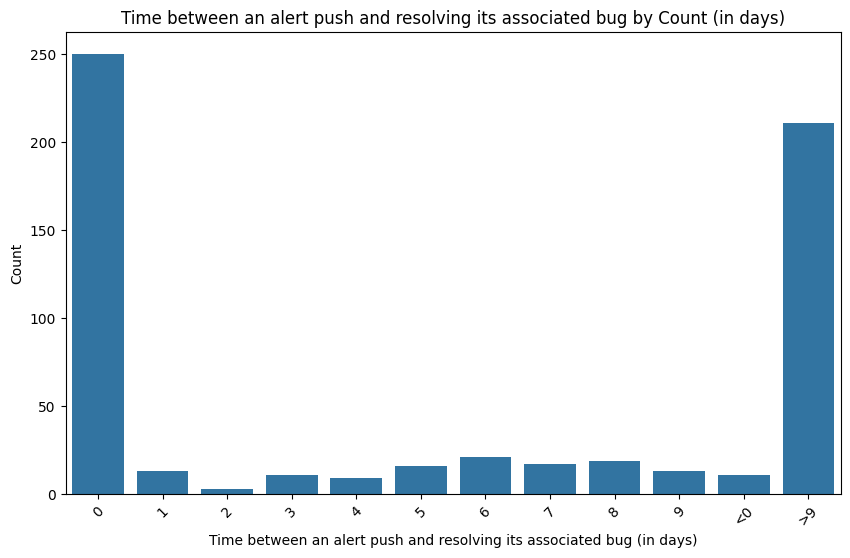

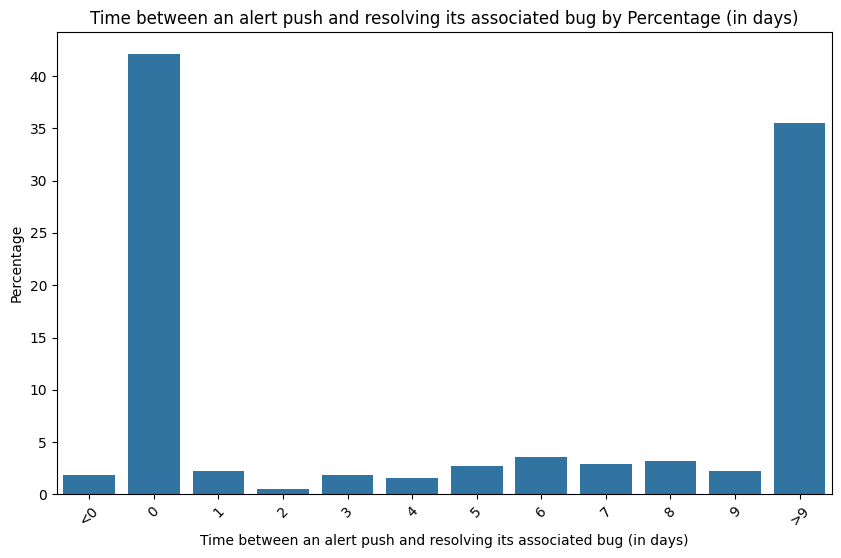

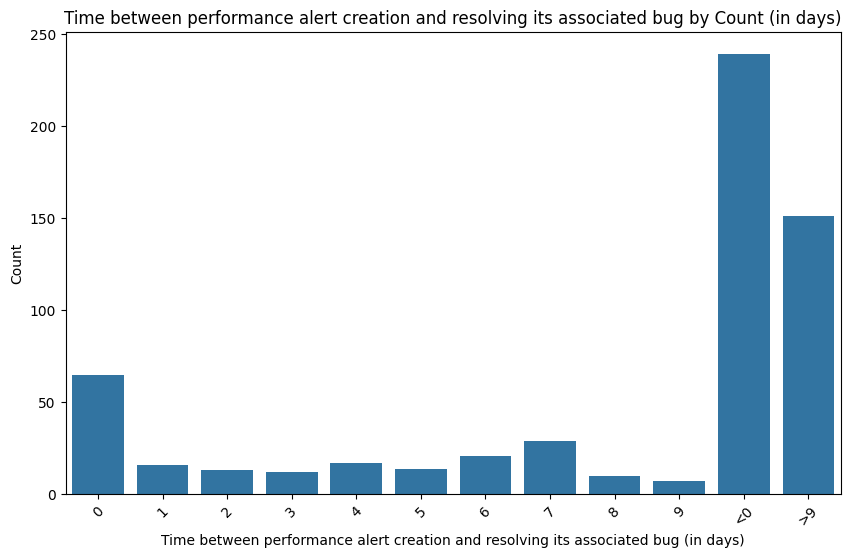

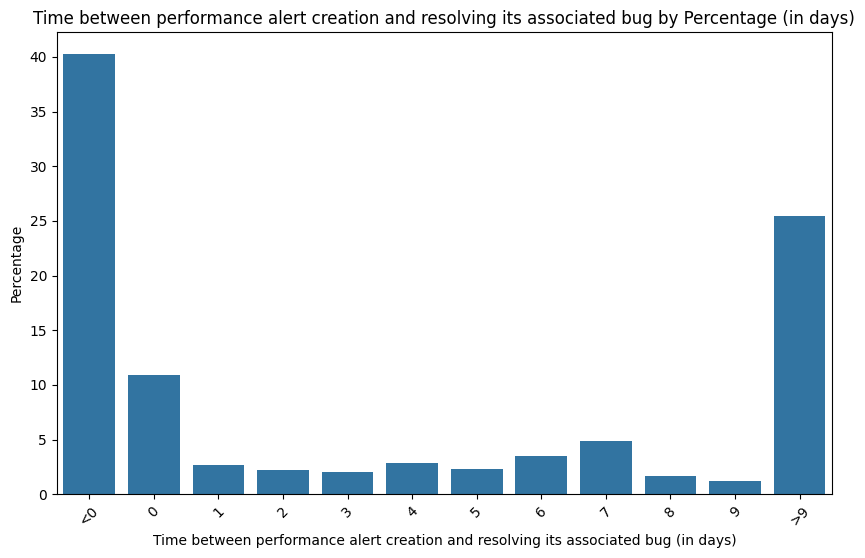

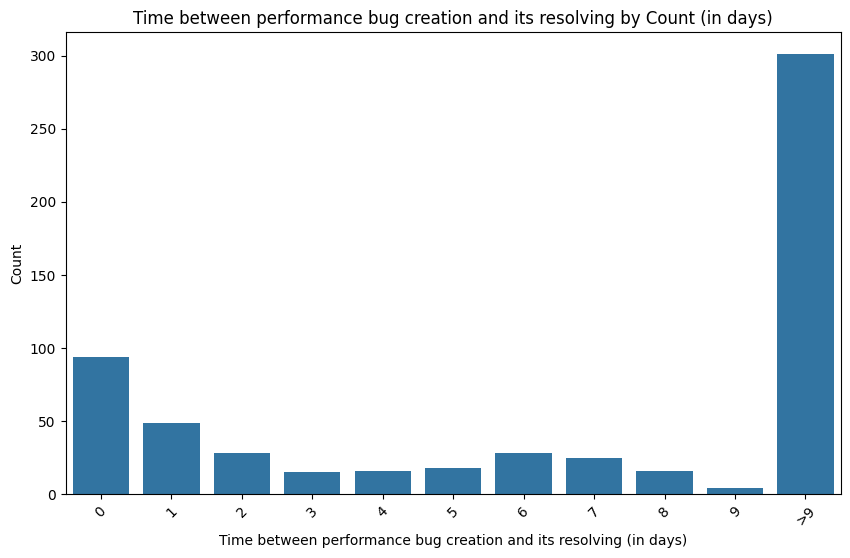

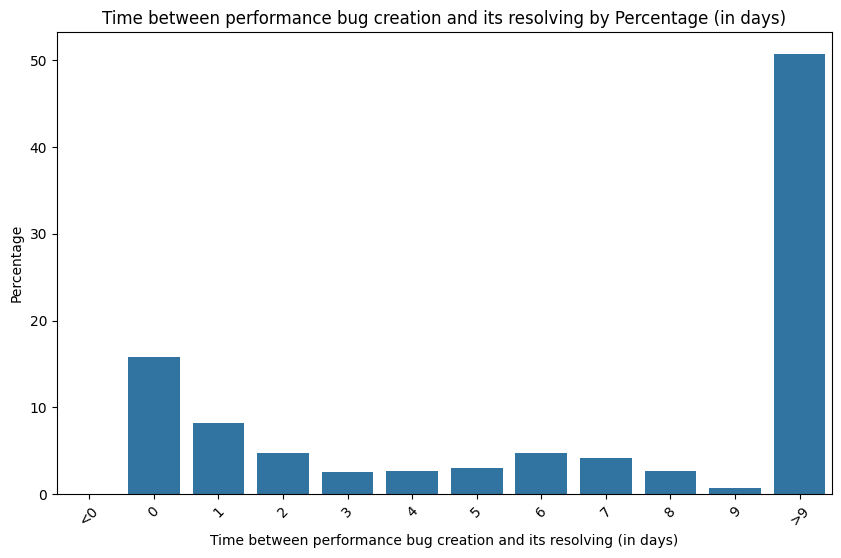

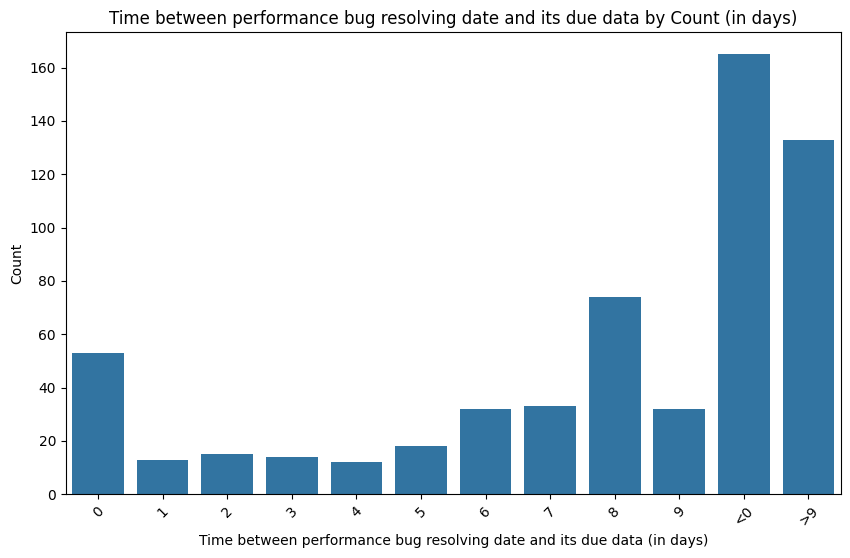

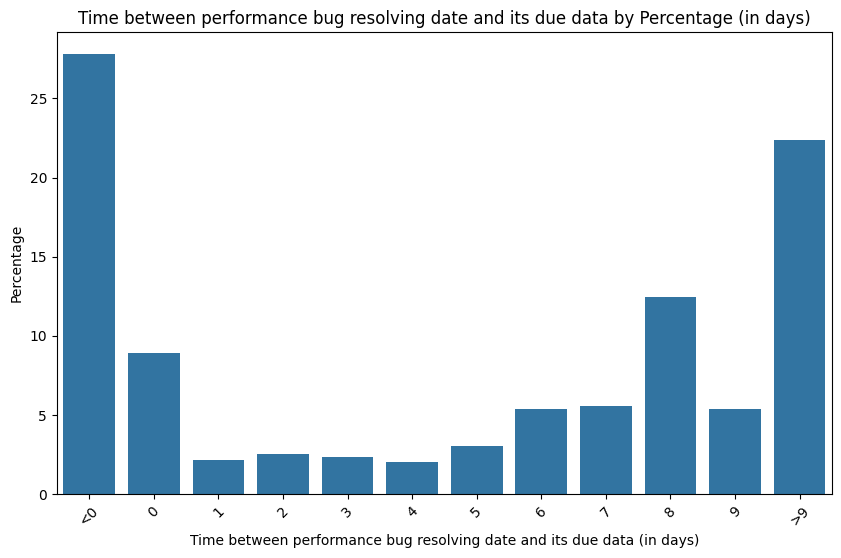

In [554]:
get_dist(df_alerts_bugs, delta_columns)

In [ ]:
display(df_alerts_bugs.head(5))

In [ ]:
print("Percentage of performance/non-performance bugs")
print(df_alerts_bugs["IsPerformanceBug"].value_counts(normalize=True) * 100)

In [ ]:
print("Percentage of alerts related to performance/non-performance bugs")
print(df_bugs["IsPerformanceBug"].value_counts(normalize=True) * 100)